------------------------------------------------------------------------------------------------------------------------
### <b>Table of Content</b>

0. Background

1. Import functions

2. Load data

3. Explore data<br>
    3-1. Examine and transform data formats<br>
    3-2. Plot histograms and box plots<br>
    3-3. Plot a correlation heatmap<br>
    3-4. Plot seasonal decomposition<br>
    3-5. Plot autocorrelations

3. build a classification model to access the performance of cloned audio's target speaker<br>
    3-1. Convert .wav to machine-readable form<br>
    3-2. train a model<br>
    3-3. evaluate classification accuracy using test data

4. first, build a voice cloning system given a speaker’s spoken audio that clones the source speaker’s voice to the target speaker’s voice<br>
    4-1. For the voice cloning system (VC), you can utilize the TIMIT dataset as it consists of aligned text-audio data with various speakers.<br>
    4-2. Use Word Error Rate (WER) for automatic evaluation of the voice cloning (VC) system for the speech generation part<br>
    &emsp; 4-2-1. speech to text<br>
    &emsp; 4-2-2. measure WER using the original script and transcribed text<br>
    4-3. also report speaker classification accuracy to assess the performance of the generated audio’s target speaker.

5. Next, build a machine learning system which detects if any spoken audio is a natural speech or synthetically generated by machine.<br>
    5-1. For the fake audio detection system (FAD) you can utilize the CommonVoice dataset as it consists of thousands of naturally spoken audio which could be used as golden spoken audio by humans as positive examples and creating negative examples using the voice cloning system as automatic data/label generator.<br>
    => can sample files from 'validated.tsv' with most upvotes?
    5-2. For the fake audio detection (FAD) system evaluate the performance of the models using F-score via positive labels coming from the groundtruth dataset and negative labels generated by the VC.



4. Select and engineer features

5. Train models<br>
    5-1. Split data into train and test sets<br>
    5-2. SARIMAX model<br>
    &emsp; 5-2-1. Perform stepwise search<br>
    &emsp; 5-2-2. Train with best orders<br>
    5-3. Train and evaluate different models<br>
    &emsp; 5-3-1. Train three different models<br>
    &emsp; 5-3-2. Compare model performance

6. Evaluate prediction results<br>
    6-1. Create Bollinger Bands<br>
    6-2. Get trading dates with different intervals<br>
    6-3. Make training decisions and get capital returns<br>
    &emsp; 6-3-1. Based on SARIMAX predictions<br>
    &emsp; 6-3-2. Based on Bollinger Band

7. Build pipeline and process all stock data<br>
    7-1. Interpret results<br>
    &emsp; 7-1-1. Capital returns<br>
    &emsp; 7-1-2. Model performance

8. Conclusion
------------------------------------------------------------------------------------------------------------------------

### <b>0. Background</b>

This project is for a cyber security company providing products and services that can detect whether audio and video media is authentic or fake.

We are given two publically available corpora of speech data, which are the <a href="https://github.com/philipperemy/timit">TIMIT</a> and <a href="https://commonvoice.mozilla.org/en/datasets">CommonVoice</a> datasets. We will build two machine learning systems using these datasets as follows:

1. A voice cloning (VC) system that clones a given speaker's spoken audio to the target speaker's voice.
2. A fake audio detection (FAD) system that detects if any spoken audio is natural speech or synthetically generated by machines.

More details can be found in <a href="https://github.com/henryhyunwookim/K7h2vHrgG1Gl0S2r#readme">README</a>.

### <b>1. Import functions</b>

In [1]:
from TTS.api import TTS

import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

import utils
from utils.load import get_variables_for_voice_cloning
from utils.save import copy_original
from utils.evaluate import transcribe_audio_and_evaluate, hyperparameter_tuning_and_evaluation
from utils.process import process_audio
from utils.split import custom_train_test_split
from utils.transform import normalize_scale
from utils.plot import plot_callbacks_history

c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


### <b>2. Load data</b>

Define file directories.

In [2]:
root_dir = Path(sys.path[0])

timit_dir = root_dir / 'data' / 'TIMIT' / 'archive'
common_voice_dir = root_dir / 'data' / 'CommonVoice' / \
    'cv-corpus-14.0-delta-2023-06-23-en.tar' / \
    'cv-corpus-14.0-delta-2023-06-23-en' / \
    'cv-corpus-14.0-delta-2023-06-23' / 'en' / 'clips'

Load CSV files.

In [3]:
train_csv = pd.read_csv(timit_dir / 'train_data.csv', index_col='index').dropna(how='all').reset_index(drop=True)
train_csv.index = train_csv.index.astype(int).astype(str)

test_csv = pd.read_csv(timit_dir / 'test_data.csv', index_col='index').dropna(how='any').reset_index(drop=True)
test_csv.index = test_csv.index.astype(int).astype(str)

train_csv.head()

,test_or_train,dialect_region,speaker_id,filename,path_from_data_dir,path_from_data_dir_windows,is_converted_audio,is_audio,is_word_file,is_phonetic_file,is_sentence_file
0,TRAIN,DR4,MMDM0,SI681.WAV.wav,TRAIN/DR4/MMDM0/SI681.WAV.wav,TRAIN\\DR4\\MMDM0\\SI681.WAV.wav,True,True,False,False,False
1,TRAIN,DR4,MMDM0,SI1311.PHN,TRAIN/DR4/MMDM0/SI1311.PHN,TRAIN\\DR4\\MMDM0\\SI1311.PHN,False,False,False,True,False
2,TRAIN,DR4,MMDM0,SI1311.WRD,TRAIN/DR4/MMDM0/SI1311.WRD,TRAIN\\DR4\\MMDM0\\SI1311.WRD,False,False,True,False,False
3,TRAIN,DR4,MMDM0,SX321.PHN,TRAIN/DR4/MMDM0/SX321.PHN,TRAIN\\DR4\\MMDM0\\SX321.PHN,False,False,False,True,False
4,TRAIN,DR4,MMDM0,SX321.WRD,TRAIN/DR4/MMDM0/SX321.WRD,TRAIN\\DR4\\MMDM0\\SX321.WRD,False,False,True,False,False


In [4]:
set(train_csv.speaker_id) & set(test_csv.speaker_id)

set()

cannot use test data (i.e., files in the 'TEST' folder or test_csv) for evaluating model performance since no labels from test data is found in train data - that is, every single label in the test data will have been unseen in the train data, meaning the model will never be able to predict the correct labels for the test data.

For this reason, train data (i.e., files in the 'TRAIN' folder or train_csv) will be split into train and test sets for modeling and evaluating model performance.

In [5]:
# Combine train and test data since 
# train_csv = pd.concat([train_csv, test_csv]).reset_index(drop=True)

In [6]:
unique_categories = set(train_csv.speaker_id)
# unique_categories = set(train_csv.speaker_id) | set(test_csv.speaker_id)
num_categories = len(unique_categories)
speaker_id_dict = {speaker_id: i for i, speaker_id in enumerate(unique_categories)}
reverse_speaker_id_dict = {v: k for k, v in speaker_id_dict.items()}

Define variables for source and target audio files for cloning.

In [7]:
train_audio_path = train_csv[train_csv['is_converted_audio']==True]['path_from_data_dir']
# test_audio_path = test_csv[test_csv['is_converted_audio']==True]['path_from_data_dir']

# sampled = train_audio_path.sample(n=2, replace=False)
# source_audio_subpath = sampled[0]
# target_audio_subpath = sampled[1]

source_audio_subpath = train_audio_path.iloc[0]
target_audio_subpath = train_audio_path.iloc[-1]

# source_audio_subpath = [path for path in train_audio_path if 'FEAC0' not in path][0]
# target_audio_subpath = [path for path in train_audio_path if 'FEAC0' in path][-1] 

source_speaker_id, source_audio_file, source_file_id, source_audio_path,\
target_speaker_id, target_audio_file, target_file_id, target_audio_path,\
source_text_file, source_text_path, source_text, output_folder, output_filename\
     = get_variables_for_voice_cloning(
        source_audio_subpath, target_audio_subpath, root_dir, timit_dir, train_csv)

Source path: d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\data\TIMIT\archive\data\TRAIN\DR4\MMDM0\SI681.WAV.wav
Target path: d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\data\TIMIT\archive\data\TRAIN\DR8\MRDM0\SA2.WAV.wav


In [141]:
Clone more files using different source and target speakers to evaluate speech_generator

SyntaxError: invalid syntax (1931938604.py, line 1)

In [9]:
# # %tb
# # https://pypi.org/project/Voice-Cloning/
# # 1. Clone using an external reference voice

# # load all the functions
# from voice_cloning.generation import speech_generator, save_sound

# generated_wav = speech_generator(
#     sound_path = str(target_audio_path), # Reference sound file
#     speech_text = source_text # Reference speech text
#     )

# ## Play and save the sound with noise-reduction capabilities

# # play the generated sound
# # play_sound(generated_wav)

# # save the file
# vc_output_path = output_folder / f'vc_{output_filename}'
# save_sound(generated_wav, filename=str(vc_output_path), noise_reduction=True) # enable noise reduction

Loaded encoder "d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\voice_cloning\saved_models/default/encoder.pt" trained to step 1564501
Synthesizer using device: cuda
Building Wave-RNN
Trainable Parameters: 4.481M
Loading model weights at d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\voice_cloning\saved_models/default/vocoder.pt
Synthesizer using device: cuda
Trainable Parameters: 30.870M
Loaded synthesizer "synthesizer.pt" trained to step 295000

| Generating 1/1


Done.

Created the mel spectrogram
Building Wave-RNN
Trainable Parameters: 4.481M
Loading model weights at saved_models\default\vocoder.pt
{| ████████████████ 38000/38400 | Batch Size: 4 | Gen Rate: 0.5kHz | }

In [ ]:
train a model and evaluate the file in
D:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\output\MMDM0-SI681_to_MRDM0-SA2\vc_MMDM0-SI681_to_MRDM0-SA2.wav.wav

In [ ]:
def normalize_volume(wav, target_dBFS, increase_only=False, decrease_only=False):
    if increase_only and decrease_only:
        raise ValueError("Both increase only and decrease only are set")
    dBFS_change = target_dBFS - 10 * np.log10(np.mean(wav ** 2))
    if (dBFS_change < 0 and increase_only) or (dBFS_change > 0 and decrease_only):
        return wav
    return wav * (10 ** (dBFS_change / 20))

3. clone audio file

Copy original source and target files to the destination folder for an easier review of the output file.

In [11]:
copy_original(output_folder, source_audio_file, source_audio_path,
            target_audio_file, target_audio_path, source_text_file, source_text_path)

d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\output\MMDM0-SI681_to_MRDM0-SA2 already exists.
SI681.WAV.wav already exists in d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\output\MMDM0-SI681_to_MRDM0-SA2.
SA2.WAV.wav already exists in d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\output\MMDM0-SI681_to_MRDM0-SA2.
SI681.TXT already exists in d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\output\MMDM0-SI681_to_MRDM0-SA2.


In [9]:
%%capture
# This is to slient/suppress print outputs

from datetime import datetime
from pydub import AudioSegment

# reduce_decibel = 0

start = datetime.now()

# Multilingual voice conversion model - voice to voice
# Downloading model to C:\Users\Admin\AppData\Local\tts\voice_conversion_models--multilingual--vctk--freevc24
multi_output_path = output_folder / f'multi_{output_filename}'
if os.path.exists(multi_output_path):
    print(f'{multi_output_path} already exists.')
else:
    print('Cloning from source audio to target audio by multilingual model.')
    multi_tts = TTS(model_name="voice_conversion_models/multilingual/vctk/freevc24", progress_bar=False, gpu=False)
    multi_tts.voice_conversion_to_file(
        source_wav=str(source_audio_path),
        target_wav=str(target_audio_path),
        file_path=multi_output_path
    )
    # Reduce volume and save it
    # (AudioSegment.from_wav(multi_output_path) - reduce_decibel).export(multi_output_path, 'wav')

# English voice conversion models - text to speech/voice
en_models = [model for model in TTS.list_models() if '/en/' in model]
for en_model in en_models:
    try:
        model_name = en_model.split('/')[-1]
        output_file_path = output_folder / f'{model_name}_{output_filename}'
        if os.path.exists(output_file_path):
            print(f'{output_file_path} already exists.')
        else:
            print(f'Cloning from source audio to target audio by {model_name} model.')
            en_tts = TTS(en_model)
            en_tts.tts_with_vc_to_file(
                source_text,
                speaker_wav=str(target_audio_path),
                file_path=output_file_path
            )
            # Reduce volume and save it
            # (AudioSegment.from_wav(output_file_path) - reduce_decibel).export(output_file_path, 'wav')
    except Exception  as e:
        print(e)
        print(f'Failed to load {model_name}.')

duration = datetime.now() - start
print(f'\nVoice cloning completed in {duration}.')

3-1. speech to text using the output file

In [12]:
eval_dict = transcribe_audio_and_evaluate(output_folder, output_filename, source_text)

In [13]:
print(f'Source text: {source_text}')
eval_df = pd.DataFrame(eval_dict).T
eval_df = eval_df.sort_values(list(eval_df.columns)[:-1], ascending=[True, True, True, False, True])
print(f'Models with perfect transcription: {list(eval_df[eval_df.Transcription==source_text].index)}')
eval_df
# The following measures are implemented:
# 1. Word Error Rate (WER), which is where this library got its name from. This
#   has long been (and arguably still is) the de facto standard for computing
#   ASR performance. - the lower the better (i.e. more accurate)
# 2. Match Error Rate (MER) - the lower the better (i.e. more accurate)
# 3. Word Information Lost (WIL) - the lower the better (i.e. more accurate)
# 4. Word Information Preserved (WIP) - the larget the better
# 5. Character Error Rate (CER) - the lower the better (i.e. more accurate)

Source text: would such an act of refusal be useful
Models with perfect transcription: ['neural', 'overflow']


,wer,mer,wil,wip,cer,Transcription
neural,0.0,0.0,0.0,1.0,0.0,would such an act of refusal be useful
overflow,0.0,0.0,0.0,1.0,0.0,would such an act of refusal be useful
capacitron-t2-c50,0.125,0.125,0.234375,0.765625,0.105263,whats such an act of refusal be useful
glow-tts,0.125,0.125,0.234375,0.765625,0.105263,was such an act of refusal be useful
jenny,0.125,0.125,0.234375,0.765625,0.105263,was such an act of refusal be useful
tacotron2-DDC,0.125,0.125,0.234375,0.765625,0.105263,whats such an act of refusal be useful
tacotron2,0.125,0.125,0.234375,0.765625,0.105263,with such an act of refusal be useful
vits--neon,0.125,0.125,0.234375,0.765625,0.105263,put such an act of refusal be useful
vits,0.125,0.125,0.234375,0.765625,0.105263,whats such an act of refusal be useful
fast,0.25,0.2,0.2,0.8,0.131579,i would such an act of refusal be useful in


# build an audio classification model to predict the speaker based on synthesized audio file

In [12]:
# import librosa
# source_audio_array, sample_rate = librosa.load(source_audio_path, sr=None)

# # Play the audio in Jupyter notebook
# from IPython.display import Audio

# Audio(data=source_audio_array, rate=sample_rate)

In [13]:
# %matplotlib inline
# from librosa.display import waveshow
# import matplotlib.pyplot as plt

# plt.figure(figsize=(6, 4))
# waveshow(source_audio_array, sr=sample_rate);

In [14]:
train_csv[train_csv['filename'].str.contains('.WAV.wav')]['speaker_id'].value_counts().unique()

array([10], dtype=int64)

take 7 as train and 3 as test for each speaker ID (i.e., label) from the original train data since each speaker provided 10 sets of audio data, as shown above.

* MFCCs – The MFCC summarizes the frequency distribution across the window size. So, it is possible to analyze both the frequency and time characteristics of the sound. This audio representation will allow us to identify features for classification. So, it will try to convert audio into some kind of features based on time and frequency characteristics that will help us to do classification.

In [15]:
n_mfcc = 40 # 40
train_size = 0.7 # 0.7

save_folder = root_dir / 'saved'
new_train_X_path = f'{save_folder}/new_train_X.csv'
new_test_X_path = f'{save_folder}/new_test_X.csv'
new_train_y_path = f'{save_folder}/new_train_y.csv'
new_test_y_path = f'{save_folder}/new_test_y.csv'

# if os.path.exists(new_train_X_path) and\
#      os.path.exists(new_test_X_path) and\
#      os.path.exists(new_train_y_path) and\
#      os.path.exists(new_test_y_path):

#      # Load CSV files to data frames
#      new_train_X = pd.read_csv(new_train_X_path)
#      new_test_X = pd.read_csv(new_test_X_path)
#      new_train_y = pd.read_csv(new_train_y_path)['label']
#      new_test_y = pd.read_csv(new_test_y_path)['label']
#      print('CSV files loaded as data frames.')

# else:
# Process audio files to get train_df
train_X, train_y, train_df = process_audio(train_audio_path, timit_dir, n_mfcc=n_mfcc)

# Split train_df into train and test sets
new_train_df, new_train_X, new_train_y, new_test_df, new_test_X, new_test_y\
     = custom_train_test_split(train_df, train_size=train_size)

# Save data frames to CSV files
new_train_X.to_csv(new_train_X_path, index=False)
new_test_X.to_csv(new_test_X_path, index=False)
new_train_y.to_csv(new_train_y_path, index=False)
new_test_y.to_csv(new_test_y_path, index=False)
print('Data frames saved as CSV files.')   

  0%|          | 5/4620 [00:00<01:35, 48.41it/s]

100%|██████████| 4620/4620 [00:55<00:00, 83.47it/s] 


OSError: Cannot save file into a non-existent directory: 'saved'

In [116]:
input_shape = (new_train_X.shape[1],)

# normalized_train_X, normalized_test_X = new_train_X, new_test_X
normalized_train_X, normalized_test_X, scaler = normalize_scale(new_train_X, new_test_X, method="standard")
# normalized_train_X, normalized_test_X, scaler = normalize_scale(new_train_X, new_test_X, method="minmax")

# label_encoder = LabelEncoder()
# train_y_cat = to_categorical(label_encoder.fit_transform(np.ravel(new_train_y)))
# test_y_cat = to_categorical(label_encoder.transform(np.ravel(new_test_y)))

# Manually encode without using LabelEncoder
encoded_train_y = new_train_y.map(speaker_id_dict)
encoded_test_y = new_test_y.map(speaker_id_dict)

sparse_train_y = np.zeros((encoded_train_y.shape[0], num_categories))
np.put_along_axis(arr=sparse_train_y, indices=encoded_train_y.values.reshape(-1,1), values=1, axis=1)

sparse_test_y = np.zeros((encoded_test_y.shape[0], num_categories))
np.put_along_axis(arr=sparse_test_y, indices=encoded_test_y.values.reshape(-1,1), values=1, axis=1)

The choice of optimizer in Keras for a multiclass classification problem depends on the architecture of your model, the nature of your dataset, and experimentation. Here are some commonly used optimizers that you can consider for multiclass classification:

1. **Adam (Adaptive Moment Estimation):**
   Adam is a popular and versatile optimizer that combines the benefits of both RMSProp and AdaGrad. It adapts the learning rate for each parameter, providing good convergence properties and fast training. It's often a good starting point due to its effectiveness in various scenarios.

   ```python
   optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
   ```
   What is the best learning rate for Adam optimizer?
      between 0.0001 and 0.01
      An optimal learning rate value (default value 0.001) means that the optimizer would update the parameters just right to reach the local minima. Varying learning rate between 0.0001 and 0.01 is considered optimal in most of the cases.

2. **RMSProp (Root Mean Square Propagation):**
   RMSProp adjusts the learning rate for each parameter based on the moving average of squared gradients. It's effective in handling sparse data and dealing with issues like vanishing and exploding gradients.

   ```python
   optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
   ```

3. **SGD (Stochastic Gradient Descent):**
   While basic, SGD can still be effective with careful tuning of the learning rate and momentum. However, it might require more manual adjustments compared to adaptive optimizers.

   ```python
   optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
   ```

4. **Adadelta:**
   Adadelta is another adaptive optimizer that adjusts the learning rate and accumulates past gradients. It's particularly useful when there's no clear initial learning rate choice.

   ```python
   optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0)
   ```

5. **Nadam:**
   Nadam combines the benefits of Nesterov accelerated gradient (NAG) and Adam. It's similar to Adam but uses NAG for gradient updates. It's often effective in practice.

   ```python
   optimizer = tf.keras.optimizers.Nadam(learning_rate=0.002)
   ```

It's important to note that the performance of optimizers can vary based on the specific problem and dataset. Experiment with multiple optimizers and different learning rates to find the best one for your model. Also, consider adjusting the learning rate during training using learning rate schedulers to achieve better convergence and performance.

In [19]:
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score

# # https://xgboost.readthedocs.io/en/stable/parameter.html
# params = {
#     'booster': ['gbtree', 'gblinear', 'dart'],
#     'learning_rate': np.arange(0, 1, 0.05),
#     'gamma': np.arange(0, 10, 0.5),
#     'max_depth': np.arange(1, 6, 1),
#     'n_estimators': np.arange(50, 500, 50)
# }

# # try hyperparameter tuning via randomized search using original X (without normalization)
# best_search = hyperparameter_tuning_and_evaluation(
#     classifier=XGBClassifier(), eval_metric='accuracy',
#     n_iter=1, cv=2, random_state=6,
#     X_train=new_train_X, y_train=encoded_train_y,
#     X_test=new_test_X, y_test=encoded_test_y,
#     params=params
# )
# best_model = best_search.best_estimator_
# accuracy_score(best_model.predict(new_test_X), encoded_test_y)
# # accuracy_score: 0.9018759018759018
# # n_iter: 1, cv: 2, best_score: 0.81, test_score: 0.9

# # XGBClassifier(base_score=None, booster='gblinear', callbacks=None,
# #               colsample_bylevel=None, colsample_bynode=None,
# #               colsample_bytree=None, early_stopping_rounds=None,
# #               enable_categorical=False, eval_metric=None, feature_types=None,
# #               gamma=7.5, gpu_id=None, grow_policy=None, importance_type=None,
# #               interaction_constraints=None, learning_rate=0.1, max_bin=None,
# #               max_cat_threshold=None, max_cat_to_onehot=None,
# #               max_delta_step=None, max_depth=5, max_leaves=None,
# #               min_child_weight=None, missing=nan, monotone_constraints=None,
# #               n_estimators=50, n_jobs=None, num_parallel_tree=None,
# #               objective='multi:softprob', predictor=None, ...)

In [20]:
from utils.statistics import f1_score

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

dropout_rate = 0.75
learning_rate = 0.008

model=Sequential()

# first layer
model.add(Dense(1024, activation='relu', input_shape=input_shape)) # 1024
model.add(Dropout(dropout_rate)) 

# second layer
model.add(Dense(1024, activation='relu')) # 1024
model.add(Dropout(dropout_rate))

# final layer
model.add(Dense(num_categories, activation='softmax'))

model.compile(
    optimizer=Adam(lr=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']) # Predicting the correct class is the primary concern in our case, 
                          # thus use 'accuracy' as the performance metric.

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              41984     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 462)               473550    
                                                                 
Total params: 1,565,134
Trainable params: 1,565,134
Non-trainable params: 0
_________________________________________________________________


In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
import pickle
import json
from tensorflow.keras.models import load_model
import numpy as np

best_model_path = f'{save_folder}/audio_classification.h5'
best_result_path = f'{save_folder}/audio_classification.json'
# scaler_path = f'{save_folder}/scaler.pkl'
# label_encoder_path = f'{save_folder}/label_encoder.pkl'
val_dict_path = f'{save_folder}/val_dict.pkl'
# checkpoint_path = f'{save_folder}/audio_classification.hdf5'

# if os.path.exists(best_result_path):
#         print('Load saved model with scaler, label encoder and results from drive.')
#         model = load_model(best_model_path)
#         # scaler = pickle.load(open(scaler_path, 'rb'))
#         # label_encoder = pickle.load(open(label_encoder_path, 'rb'))
#         history = json.load(open(best_result_path, 'r'))
#         # val_dict = {int(k): v for k, v in json.load(open(val_dict_path, 'r')).items()}
#         val_dict = json.load(open(val_dict_path, 'r'))

# else:
num_epochs = 60 # 100
num_batch_size = 64 # 64

# checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=2, save_best_only=True)

start = datetime.now()

history = model.fit(
        normalized_train_X,
        # new_train_X,
        sparse_train_y,
        batch_size=num_batch_size,
        epochs=num_epochs,
        validation_data=(normalized_test_X, sparse_test_y),
        # validation_data=(new_test_X, sparse_test_y),
        # callbacks=[checkpointer],
        verbose=2
        )
# By default verbose = 1,
# verbose = 1, which includes both progress bar and one line per epoch
# verbose = 0, means silent
# verbose = 2, one line per epoch i.e. epoch no./total no. of epochs

duration = datetime.now() - start
print(f'\nTraining completed in {duration}.')

# Convert the tf.keras.callbacks.History object into a dictionary, if not loaded from local drive.
if not isinstance(history, dict):
        history = {**history.params, 'epoch': history.epoch, **history.history}

val_dict = {}
label_list = new_test_y.drop_duplicates().values
idx_list = np.arange(0, normalized_test_X.shape[0], 3)
for label, idx in zip(label_list, idx_list):
        val_X = normalized_test_X[idx : idx+3]
        val_y = sparse_test_y[idx : idx+3]
        val_loss, val_accuracy = model.evaluate(val_X, val_y, verbose=0)
        val_dict[label] = {'val_loss': val_loss, 'val_accuracy': val_accuracy}

Epoch 1/60
51/51 - 5s - loss: 6.2465 - accuracy: 0.0059 - val_loss: 5.8435 - val_accuracy: 0.0938 - 5s/epoch - 92ms/step
Epoch 2/60
51/51 - 3s - loss: 5.6940 - accuracy: 0.0238 - val_loss: 5.0484 - val_accuracy: 0.2107 - 3s/epoch - 64ms/step
Epoch 3/60
51/51 - 4s - loss: 5.1086 - accuracy: 0.0501 - val_loss: 4.1060 - val_accuracy: 0.4062 - 4s/epoch - 78ms/step
Epoch 4/60
51/51 - 4s - loss: 4.4583 - accuracy: 0.0955 - val_loss: 3.2117 - val_accuracy: 0.5159 - 4s/epoch - 72ms/step
Epoch 5/60
51/51 - 6s - loss: 3.8315 - accuracy: 0.1565 - val_loss: 2.5622 - val_accuracy: 0.6356 - 6s/epoch - 110ms/step
Epoch 6/60
51/51 - 5s - loss: 3.3889 - accuracy: 0.2288 - val_loss: 2.0525 - val_accuracy: 0.6984 - 5s/epoch - 94ms/step
Epoch 7/60
51/51 - 4s - loss: 2.9710 - accuracy: 0.2910 - val_loss: 1.7092 - val_accuracy: 0.7453 - 4s/epoch - 82ms/step
Epoch 8/60
51/51 - 4s - loss: 2.7531 - accuracy: 0.3302 - val_loss: 1.4598 - val_accuracy: 0.7850 - 4s/epoch - 80ms/step
Epoch 9/60
51/51 - 4s - loss: 2

In [22]:
# best_model.predict()

In [23]:
# Evaluate the model
test_loss, test_acc = model.evaluate(normalized_test_X, sparse_test_y)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

for k, v in history.items():
    best_score = None
    if 'loss' in k:
        best_score = min(v)
    elif 'accuracy' in k:
        best_score = max(v)

    if best_score != None:
        print(f'Best {k}: {round(best_score, 4)}')

 7/44 [===>..........................] - ETA: 0s - loss: 0.3043 - accuracy: 0.9375

44/44 [==============================] - 1s 10ms/step - loss: 0.3111 - accuracy: 0.9271
Test loss: 0.3110729157924652
Test accuracy: 0.9271284341812134
Best loss: 0.4614
Best accuracy: 0.8639
Best val_loss: 0.3111
Best val_accuracy: 0.9271


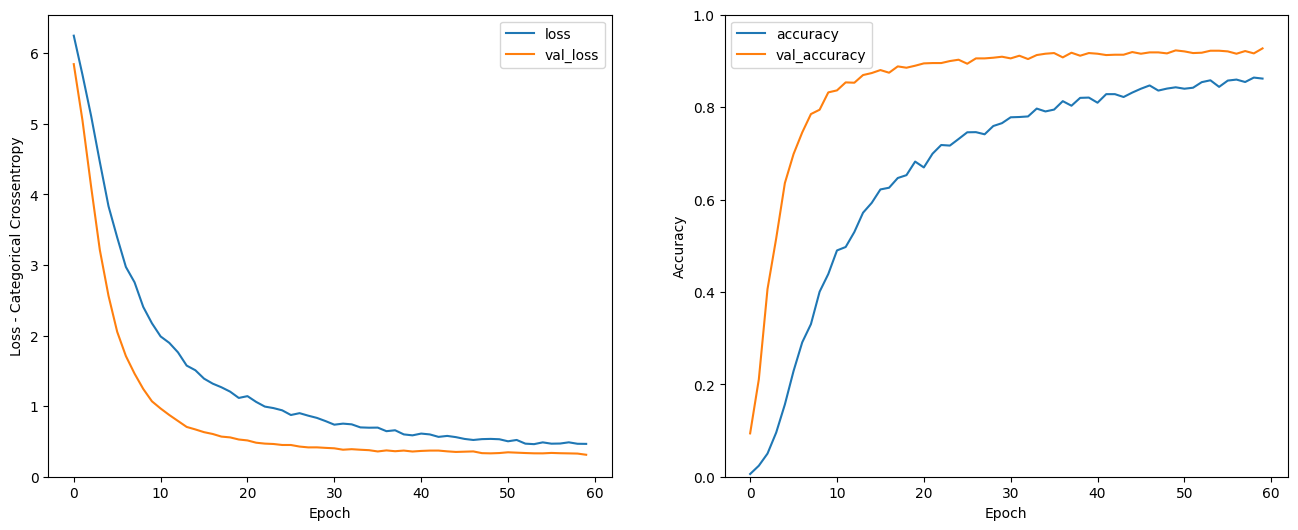

In [24]:
%matplotlib inline
plot_callbacks_history(history, figsize=(16, 6), eval_metrics=['Categorical Crossentropy', 'Accuracy'])

In [25]:
val_df = pd.DataFrame(val_dict).T
val_df = val_df.sort_values(['val_accuracy', 'val_loss'], ascending =[False, True])
val_df

,val_loss,val_accuracy
MAEO0,0.000012,1.000000
FGMB0,0.000020,1.000000
MWSH0,0.000103,1.000000
MDWD0,0.000182,1.000000
MESJ0,0.000209,1.000000
...,...,...
MTER0,1.662958,0.333333
MDLB0,1.725610,0.333333
MFMC0,1.818958,0.333333
MRAB1,2.272264,0.333333


In [26]:
# Saving the model and other objects

# model.save(best_model_path)
# # pickle.dump(scaler, open(scaler_path, 'wb'))
# # pickle.dump(label_encoder, open(label_encoder_path, 'wb'))
# json.dump(history, open(best_result_path, 'w'))
# json.dump(val_dict, open(val_dict_path, 'w'))

Considering we only have 10 audio files for both training and validation, an accuracy score over 90% is very good.

Moving on to verifying whether cloned audio files are correctly classified as the original speaker.

In [117]:
# Iterate through all cloned audio files
import librosa
from sklearn.preprocessing import StandardScaler

X_list = []
y_list = []
for folder in os.listdir(root_dir / 'output'):
    for file in os.listdir(root_dir / 'output' / folder):
        if '_to_' in file:
            wav_path = root_dir / 'output' / folder / file
            label = file.split('_to_')[1].split('-')[0]
            y_list.append(label)

            audio_array, sample_rate = librosa.load(wav_path, sr=None)
            # print(f'Shape of audio array: {audio_array.shape}')
            mfccs_features = librosa.feature.mfcc(y=audio_array, sr=sample_rate, n_mfcc=n_mfcc)
            # print(f'Shape of mfccs features: {mfccs_features.shape}')
            normalized_mfccs_features = np.mean(mfccs_features.T, axis=0)
            # print(f'Shape of scaled mfccs features: {normalized_mfccs_features.shape}')
            X_list.append(normalized_mfccs_features)

            # scaled_X = StandardScaler().fit_transform(normalized_mfccs_features.reshape(-1, 1)).reshape(1, -1)[0]
            # X_list.append(scaled_X)

df = pd.DataFrame(X_list)
df['label'] = y_list

X = df.drop(['label'], axis=1)
y = df[['label']]

In [118]:
# # Iterate through cloned audio files in a single folder

# # perfect_transcription_models = eval_df[eval_df['Transcription']==source_text].index
# X_list = []
# for filename in os.listdir(output_folder):
#     # if filename.split('_')[0] in perfect_transcription_models:
#     if (source_file_id in filename) and (target_file_id in filename):
#         wav_path = output_folder / filename
#         model_name = filename.split('/')[-1].split('_')[0]

#         audio_array, sample_rate = librosa.load(wav_path, sr=None)
#         # print(f'Shape of audio array: {audio_array.shape}')
#         mfccs_features = librosa.feature.mfcc(y=audio_array * 0.1, sr=sample_rate, n_mfcc=n_mfcc)
#         # print(f'Shape of mfccs features: {mfccs_features.shape}')
#         normalized_mfccs_features = np.mean(mfccs_features.T, axis=0)
#         # print(f'Shape of scaled mfccs features: {normalized_mfccs_features.shape}')
#         X_list.append(normalized_mfccs_features)

#         # S = np.abs(librosa.stft(audio_array))
#         # transformed_s = librosa.amplitude_to_db(S, ref=np.max)
#         # normalized_s = np.mean(transformed_s.T, axis=0)
#         # X_list.append(normalized_s)
        
# df = pd.DataFrame(X_list)
# df['label'] = target_speaker_id

# X = df.drop(['label'], axis=1)
# y = df[['label']]

In [119]:
# normalized_X = X
normalized_X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)

# from sklearn.preprocessing import StandardScaler
# test_scaler = StandardScaler()
# test_scaler.fit_transform(new_train_X)
# normalized_X = pd.DataFrame(test_scaler.transform(X),
#                         index=X.index, columns=X.columns)
                        
# normalized_X = ((X - np.mean(X, axis=0)) / np.std(X, axis=0))

encoded_y = y['label'].map(speaker_id_dict)
sparse_y = np.zeros((encoded_y.shape[0], num_categories))
np.put_along_axis(arr=sparse_y, indices=encoded_y.values.reshape(-1,1), values=1, axis=1)

# model.evaluate(normalized_X, sparse_y)
model.evaluate(X, sparse_y)
# for label, encoded in zip(y.values, encoded_y):
#     print(f'True label: {label} ({encoded})')
# print(f'True label: {y.values} ({encoded_y.values})')

1/1 [==============================] - 0s 62ms/step - loss: 1115.0032 - accuracy: 0.0000e+00


[1115.003173828125, 0.0]

In [120]:
# accuracy_score(encoded_y, best_search.best_estimator_.predict(normalized_X))

In [121]:
code_pred = np.argmax(model.predict(normalized_X), axis=1)
code_pred

1/1 [==============================] - 0s 42ms/step


array([203], dtype=int64)

In [122]:
pred_prob = np.max(model.predict(normalized_X), axis=1)
pred_prob
# np.max(model.predict(X), axis=1)
# Some of the predictions have low probabilities, e.g., below 0.5.

1/1 [==============================] - 0s 47ms/step


array([0.69554347], dtype=float32)

In [123]:
predicted_labels = [reverse_speaker_id_dict[pred] for pred in code_pred]

result = y.copy()
result['label_code'] = encoded_y
result['pred'] = predicted_labels
result['pred_code'] = code_pred
result['pred_prob'] = pred_prob
result['matched'] = result['label'] == result['pred']
result

,label,label_code,pred,pred_code,pred_prob,matched
0,MRDM0,412,MSAT0,203,0.695543,False


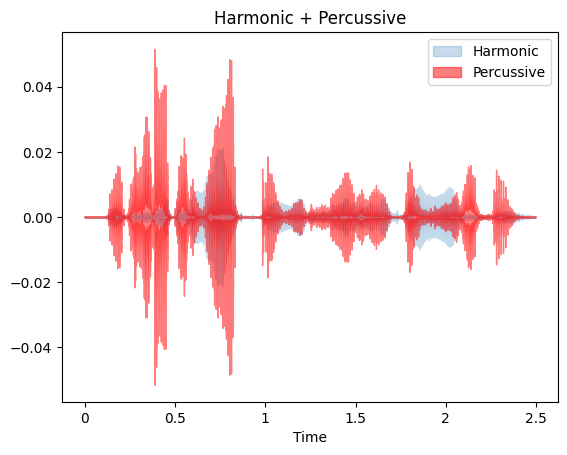

In [124]:
# %matplotlib inline
from librosa.display import waveshow
import matplotlib.pyplot as plt

source_y, sr = librosa.load(source_audio_path) # , duration=10
y_harm, y_perc = librosa.effects.hpss(source_y)
waveshow(y_harm, sr=sr, alpha=0.25, label='Harmonic')
waveshow(y_perc, sr=sr, color='r', alpha=0.5, label='Percussive')
plt.legend()
plt.title('Harmonic + Percussive');

In [125]:
y_harm.shape, y_perc.shape

((55037,), (55037,))

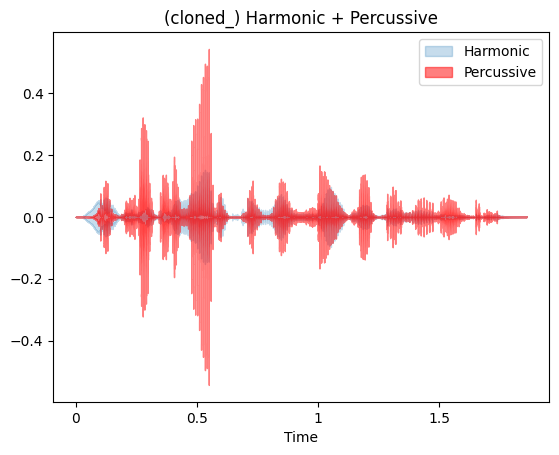

In [126]:
cloned_y, cloned_sr = librosa.load(wav_path) # , duration=10
cloned_y_harm, cloned_y_perc = librosa.effects.hpss(cloned_y)
waveshow(cloned_y_harm, sr=cloned_sr, alpha=0.25, label='Harmonic')
waveshow(cloned_y_perc, sr=cloned_sr, color='r', alpha=0.5, label='Percussive')
plt.legend()
plt.title('(cloned_) Harmonic + Percussive');

In [127]:
cloned_y_harm.shape, cloned_y_perc.shape

((41013,), (41013,))

In [128]:
# https://www.kaggle.com/code/seriousran/mfcc-feature-extraction-for-sound-classification

# https://librosa.org/doc/main/generated/librosa.feature.mfcc.html

# https://librosa.org/doc/main/generated/librosa.stft.html#librosa.stft

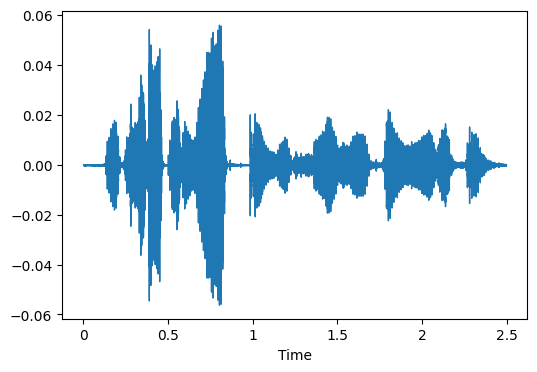

In [129]:
source_audio_array, sample_rate = librosa.load(source_audio_path, sr=None)
plt.figure(figsize=(6, 4))
waveshow(source_audio_array, sr=sample_rate);

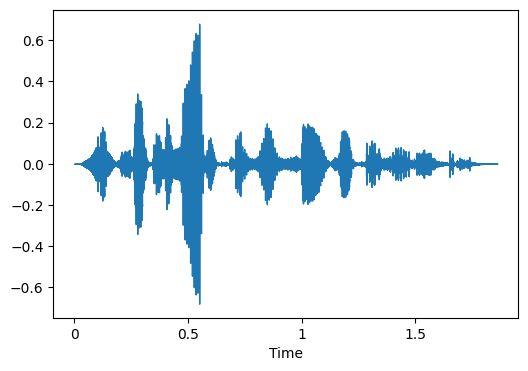

In [130]:
cloned_audio_array, cloned_sample_rate = librosa.load(wav_path, sr=None)
plt.figure(figsize=(6, 4))
waveshow(cloned_audio_array, sr=cloned_sample_rate);

In [131]:
mfccs_features = librosa.feature.mfcc(y=source_audio_array, sr=sample_rate, n_mfcc=n_mfcc) # , S=source_s
normalized_mfccs_features = np.mean(mfccs_features.T, axis=0)
pd.DataFrame(normalized_mfccs_features).describe()

,0
count,40.000000
mean,-13.653946
std,73.192215
min,-459.484833
25%,-5.758507
50%,-2.680323
75%,-1.181450
max,56.761337


In [132]:
cloned_mfccs_features = librosa.feature.mfcc(y=cloned_audio_array/5, sr=cloned_sample_rate, n_mfcc=n_mfcc)
cloned_normalized_mfccs_features = np.mean(cloned_mfccs_features.T, axis=0)
pd.DataFrame(cloned_normalized_mfccs_features).describe()

,0
count,40.000000
mean,-9.902529
std,68.452148
min,-421.152374
25%,-4.777013
50%,-1.260480
75%,0.157909
max,86.227325


In [133]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
scaler = StandardScaler()
pd.DataFrame(scaler.fit_transform(normalized_mfccs_features.reshape(-1, 1))).describe()

,0
count,4.000000e+01
mean,5.960465e-09
std,1.012739e+00
min,-6.168832e+00
25%,1.092469e-01
50%,1.518388e-01
75%,1.725783e-01
max,9.743158e-01


In [134]:
pd.DataFrame(scaler.transform(cloned_normalized_mfccs_features.reshape(-1, 1))).describe()

,0
count,40.000000
mean,0.051907
std,0.947152
min,-5.638437
25%,0.122828
50%,0.171485
75%,0.191111
max,1.382028


In [135]:
source_audio_array.shape, cloned_audio_array.shape

((39936,), (29760,))

In [136]:
mfccs_features.shape, cloned_mfccs_features.shape

((40, 79), (40, 59))

In [137]:
normalized_mfccs_features.shape, cloned_normalized_mfccs_features.shape

((40,), (40,))

In [138]:
# Play the audio in Jupyter notebook
from IPython.display import Audio
Audio(data=source_audio_array, rate=sample_rate)

In [139]:
# Play the audio in Jupyter notebook
from IPython.display import Audio
Audio(data=cloned_audio_array, rate=cloned_sample_rate)

https://librosa.org/doc/main/generated/librosa.feature.mfcc.html
https://librosa.org/doc/main/generated/librosa.stft.html#librosa.stft

https://pypi.org/project/Voice-Cloning/0.0.2/

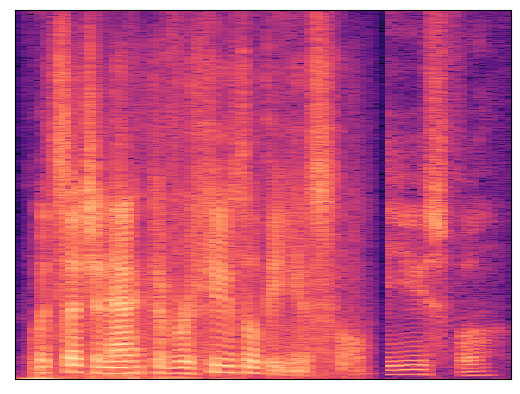

In [140]:
source_s = np.abs(librosa.stft(source_audio_array))
cloned_s = np.abs(librosa.stft(cloned_audio_array))
librosa.display.specshow(source_s)
librosa.display.specshow(cloned_s)

librosa.display.specshow(librosa.amplitude_to_db(source_s, ref=np.max))
librosa.display.specshow(librosa.amplitude_to_db(cloned_s, ref=np.max))

librosa.display.specshow(librosa.power_to_db(source_s, ref=np.max))
librosa.display.specshow(librosa.power_to_db(cloned_s, ref=np.max))